## Basic SVOL

Our model: https://mc-stan.org/docs/stan-users-guide/stochastic-volatility-models.html

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm, truncnorm, norm
import statsmodels.api as sm
import pyjags
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('dark', {'axes.grid' : False})

## Sampling

In [3]:
# sampling configs
ITERS=9000
CHAINS=2
BURN_IN=1000

In [4]:
'''
  JAGS sampling
  params:
    dataset, mlv(mean log volatility), ss(shock scale)
  returns:
    samples
'''
def jags_sampling(dataset, mlv, ss, parameters, init_vals = []):

  # JAGS sampling
  jags_data = {"y": list(dataset), "N": len(dataset), "mlv": mlv, "ss": ss}
  jags_model_string = '''
    model {
      mu ~ dnorm(0, 1/mlv)         # variance is inverse of the precision parameter
      phi ~ dunif(-1, 1)
      sigma ~ dnorm(0, 1/ss) T(0,)

      h[1] ~ dnorm(mu, sqrt(1 - pow(phi, 2))/sigma )
      for (i in 2:N) {
        h[i] ~ dnorm(mu + phi * (h[i-1] - mu), 1/sigma)
      }

      for (j in 1:N) {
        y[j] ~ dnorm(0, 1/exp(h[j]/2) )
      }
    }
  '''

  jags_model = pyjags.Model(code=jags_model_string, data=jags_data, chains=CHAINS, adapt=BURN_IN, init=init_vals)
  jags_samples = jags_model.sample(iterations=ITERS, vars=parameters)

  # chains
  return [jags_samples[p][0] for p in parameters]

In [5]:
'''
  check convergence via Gelman-Rubin statistic
  extract posterior distributions' information
  params:
    chains of all the posterior data
  returns:
    posterior distribution information
'''
def extract_posterior_data(sample_chains, parameters):

  # checking convergence

  sample_chains_np = np.array(sample_chains)
  posterior_info = {}
  print(f'\nCHAINS: {CHAINS}, ITERS: {ITERS}, BURN-IN: {BURN_IN}')

  for p in range(len(parameters)):

    # means
    _chains = sample_chains_np[p].T
    _x = np.mean(_chains)
    chain_means = np.mean(_chains, axis=1)

    # Gelman-Rubin Statistic
    varB = (ITERS/(CHAINS-1))*np.sum([(_x - x)**2 for x in chain_means])
    varW = sum( [ sum( [(chain_means[i] - s)**2 for s in _chains[i]] )/(ITERS - 1) for i in range(len(_chains)) ] ) / CHAINS
    varM = ((ITERS-1)*varW + varB)/ITERS
    R = np.sqrt(varM/varW)

    # mode & 95% interval
    chain_modes = []
    chain_intervals = []

    for ch in _chains:

      kde = sm.nonparametric.KDEUnivariate(ch)
      kde.fit(bw=1.5)
      xs = np.linspace(np.min(ch), np.max(ch), 1000)
      ys = [kde.evaluate(x) for x in xs]
      chain_modes.append(xs[np.argmax(ys)])

      sorted_chain = np.sort(ch)
      n = len(sorted_chain)
      interval_width = int(n * 0.95)
      lower_bound = sorted_chain[(n - interval_width)//2]
      upper_bound = sorted_chain[-((n - interval_width)//2 + 1)]
      chain_intervals.append([lower_bound, upper_bound])


    posterior_info[parameters[p]] = {
      'means': chain_means,
      'modes': chain_modes,
      'intervals': chain_intervals, 
      'R': R
    }

  return posterior_info


In [6]:
'''
  plot posterior distributions & samples by steps
'''
def plot_samples(sample_chains, parameters):

  fig, axs = plt.subplots(len(parameters), 2, figsize=(10, 8))
  axs[0, 0].set_title('Samples\' distribution: value vs. probability density')
  axs[0, 1].set_title('Sampling steps: Step# vs. sample value')
  colors = ['brown', 'indigo']

  for p in range(len(parameters)):

    for c in range(CHAINS):
      # samples' distribution
      sns.kdeplot(data=sample_chains[p][:, c], ax=axs[p, 0], color=colors[c], fill=True, alpha=0.7)
      # sampling steps
      sns.lineplot(data=sample_chains[p][:, c], ax=axs[p, 1], color=colors[c], alpha=0.7)

    # axs[p, 0].set_facecolor('black')
    axs[p, 0].set_ylabel(parameters[p])
    # axs[p, 1].set_facecolor('black')

  fig.suptitle(f'MCMC sampling with pyjags with {CHAINS} chains')
  plt.tight_layout()
  plt.show()

## Historical data
- Historical data of stock & cryptocurrency prices from [Investing.com](https://www.investing.com/)
- Data ranging from 01-01-2015 to 31-12-2022

In [296]:
# data

df = pd.read_csv('datasets/ETH.csv')
print(df.shape)
df.head()

(1456, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,01/01/2019,139.15,131.29,139.78,130.06,245.68K,5.98%
1,01/02/2019,152.05,139.11,155.06,137.94,302.33K,9.28%
2,01/03/2019,146.04,152.05,153.49,143.48,226.68K,-3.96%
3,01/04/2019,152.10,146.17,154.57,144.31,249.08K,4.15%
4,01/05/2019,152.85,152.05,159.00,151.98,274.10K,0.50%


In [297]:
df.describe()

,Price
count,1456.000000
mean,1313.510907
std,1282.781299
min,104.420000
25%,202.710000
50%,733.765000
75%,2160.782500
max,4808.090000


In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1456 non-null   object 
 1   Price     1456 non-null   float64
 2   Open      1456 non-null   object 
 3   High      1456 non-null   object 
 4   Low       1456 non-null   object 
 5   Vol.      1455 non-null   object 
 6   Change %  1456 non-null   object 
dtypes: float64(1), object(6)
memory usage: 79.8+ KB


In [299]:
'''
  convert string to datetime
  change formats as required for the dates
  '%m/%d/%Y'
  '%b %d, %Y'
'''

df['Date'] = df['Date'].apply(lambda dt: datetime.strptime(dt, "%m/%d/%Y"))

In [300]:
# sorting data chronologically

df.sort_values(by='Date', inplace=True)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-01,139.15,131.29,139.78,130.06,245.68K,5.98%
1,2019-01-02,152.05,139.11,155.06,137.94,302.33K,9.28%
2,2019-01-03,146.04,152.05,153.49,143.48,226.68K,-3.96%
3,2019-01-04,152.10,146.17,154.57,144.31,249.08K,4.15%
4,2019-01-05,152.85,152.05,159.00,151.98,274.10K,0.50%


In [301]:
# get asset returns from closing prices
# yt = 100 * (log(Pt) - log(Pt-1))
df['Asset_return'] = np.log(df['Price'].shift(-1) / df['Price']) * 100
df['Asset_return'] = df['Asset_return'].shift(1)

df[['Asset_return']].head()

,Asset_return
0,NaN
1,8.865693
2,-4.032886
3,4.065764
4,0.491885


In [302]:
# have asset returns mean-corrected

ar_mean = df[['Asset_return']].mean()
df['Asset_return'] = df['Asset_return'].apply(lambda a: a - ar_mean)

In [303]:
# asset returns, removing the first NaN
asset_returns_data = df[['Asset_return']].to_numpy().flatten()[1:]

print(f'''Asset return data (mean-corrected):
  Mean: {np.mean(asset_returns_data)},
  Variance: {np.var(asset_returns_data)}'''
)

Asset return data (mean-corrected):
  Mean: 5.860146274310105e-17,
  Variance: 25.66956526134562


<AxesSubplot: ylabel='Density'>

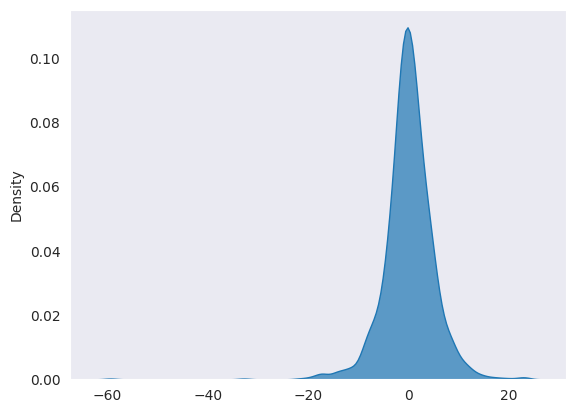

In [304]:
sns.kdeplot(data=asset_returns_data, fill=True, alpha=0.7)

In [305]:
########## Random initial values & setting proposal distribution paramters ###########

sd = np.std(asset_returns_data)

# Mean log volatility(mu): draw randomly from a normal distribution with mean 0, SD of logarithmic returns
mlv = np.random.normal(loc=0, scale=sd)

# Persistence of volatility(phi): draw randomly from a uniform distribution between 0 to 1
per = np.random.uniform(low=-1.0, high=1.0)

# Shock scale(sigma) distribution tends to be more heavy-tailed than the swing in prices itself
# We draw from distribution twice as wide as that for mlv
ss = truncnorm.rvs(a=0, b=float('inf'), loc=0, scale=2*sd)

init_vals={'mu': mlv, 'phi': per, 'sigma': ss}

print(f'''Initializer.....
  Mean log volatility: {mlv}
  Persistence of volatility: {per}
  Shock scale: {ss}''')


Initializer.....
  Mean log volatility: 2.5844819349387733
  Persistence of volatility: -0.023378579673178468
  Shock scale: 25.04721394052696


In [306]:
parameters = ['mu', 'phi', 'sigma']
sample_chains = jags_sampling(dataset=asset_returns_data, mlv=sd**2, ss=2*sd**2, parameters=parameters, init_vals=init_vals)

adapting: iterations 1856 of 2000, elapsed 0:00:08, remaining 0:00:01
adapting: iterations 2000 of 2000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 2310 of 18000, elapsed 0:00:10, remaining 0:01:05
sampling: iterations 4724 of 18000, elapsed 0:00:19, remaining 0:00:54
sampling: iterations 5946 of 18000, elapsed 0:00:24, remaining 0:00:49
sampling: iterations 8386 of 18000, elapsed 0:00:34, remaining 0:00:39
sampling: iterations 9612 of 18000, elapsed 0:00:39, remaining 0:00:34
sampling: iterations 10836 of 18000, elapsed 0:00:44, remaining 0:00:29
sampling: iterations 12056 of 18000, elapsed 0:00:50, remaining 0:00:24
sampling: iterations 14488 of 18000, elapsed 0:01:00, remaining 0:00:14
sampling: iterations 15704 of 18000, elapsed 0:01:05, remaining 0:00:09
sampling: iterations 16916 of 18000, elapsed 0:01:10, remaining 0:00:04
sampling: iterations 18000 of 18000, elapsed 0:01:14, remaining 0:00:00


In [307]:
posterior_info = extract_posterior_data(sample_chains, parameters)
posterior_info


CHAINS: 2, ITERS: 9000, BURN-IN: 1000


{'mu': {'means': array([5.41781857, 5.41735401]),
  'modes': [5.418268935714951, 5.416865074222537],
  'intervals': [[5.073509993822272, 5.796209861758979],
   [5.0780268331729195, 5.773614312420582]],
  'R': 0.9999461016907862},
 'phi': {'means': array([0.76515894, 0.7606858 ]),
  'modes': [0.7653314524885352, 0.7608798987731598],
  'intervals': [[0.5795502104337757, 0.8671046260939779],
   [0.6136422705617567, 0.8634185000380581]],
  'R': 1.0010027701364177},
 'sigma': {'means': array([1.57840655, 1.63754972]),
  'modes': [1.5472045258272447, 1.624210509794355],
  'intervals': [[0.8156275956519081, 2.889843147717559],
   [0.903381956037961, 2.618348005743221]],
  'R': 1.0033830411351599}}

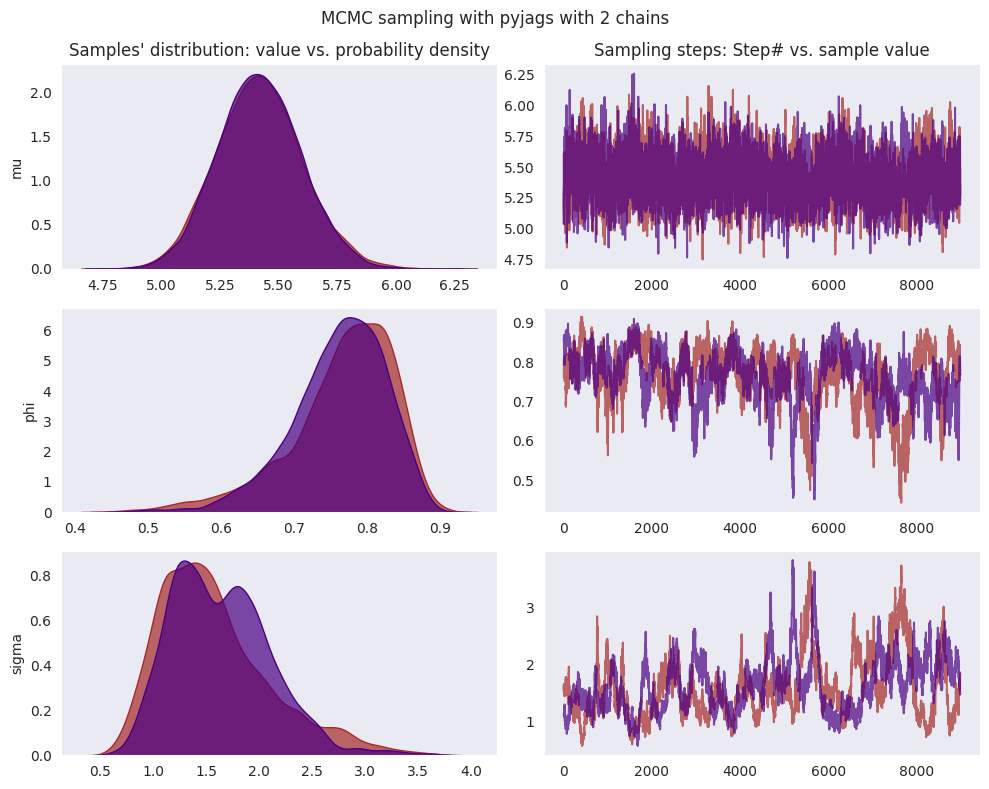

In [308]:
plot_samples(sample_chains, parameters)

In [309]:
'''
  Now we try to validate our estimates,
  Plugging in values from posterior to see if we get the same estimates
'''

_mlv=posterior_info['mu']['modes'][0]
_per=posterior_info['phi']['modes'][0]
_ss=posterior_info['sigma']['modes'][0]
_init_vals={'mu': _mlv, 'phi': _per, 'sigma': _ss}
print(f'''Initializing from posterior samples' distribution
  mu: {_mlv}
  phi: {_per}
  sigma: {_ss}''')

Initializing from posterior samples' distribution
  mu: 5.418268935714951
  phi: 0.7653314524885352
  sigma: 1.5472045258272447


In [310]:
_sample_chains = jags_sampling(dataset=asset_returns_data, mlv=data_sd**2, ss=2*data_sd**2, parameters=parameters, init_vals=_init_vals)

adapting: iterations 2000 of 2000, elapsed 0:00:08, remaining 0:00:00
adapting: iterations 2000 of 2000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 2418 of 18000, elapsed 0:00:09, remaining 0:00:59
sampling: iterations 3748 of 18000, elapsed 0:00:14, remaining 0:00:54
sampling: iterations 5076 of 18000, elapsed 0:00:19, remaining 0:00:49
sampling: iterations 6400 of 18000, elapsed 0:00:24, remaining 0:00:44
sampling: iterations 7714 of 18000, elapsed 0:00:29, remaining 0:00:39
sampling: iterations 9026 of 18000, elapsed 0:00:35, remaining 0:00:34
sampling: iterations 11632 of 18000, elapsed 0:00:45, remaining 0:00:24
sampling: iterations 14238 of 18000, elapsed 0:00:54, remaining 0:00:14
sampling: iterations 16856 of 18000, elapsed 0:01:04, remaining 0:00:04
sampling: iterations 18000 of 18000, elapsed 0:01:09, remaining 0:00:00


In [311]:
_posterior_info = extract_posterior_data(_sample_chains, parameters)
_posterior_info


CHAINS: 2, ITERS: 9000, BURN-IN: 1000


{'mu': {'means': array([5.41790909, 5.44430094]),
  'modes': [5.418290448826141, 5.444796343574522],
  'intervals': [[5.084812505174078, 5.771554673084751],
   [5.096658891915562, 5.8083944852113305]],
  'R': 1.0054452652496155},
 'phi': {'means': array([0.76399078, 0.78437396]),
  'modes': [0.7639279029291639, 0.7842348522592569],
  'intervals': [[0.6385096573283334, 0.8742194288004782],
   [0.6689674973756256, 0.8680488694624882]],
  'R': 1.033312696314216},
 'sigma': {'means': array([1.59007649, 1.45010204]),
  'modes': [1.5841039655738076, 1.4429984819594255],
  'intervals': [[0.7957845513048992, 2.574386581551569],
   [0.872767070930729, 2.3591942973274755]],
  'R': 1.0303708697095015}}

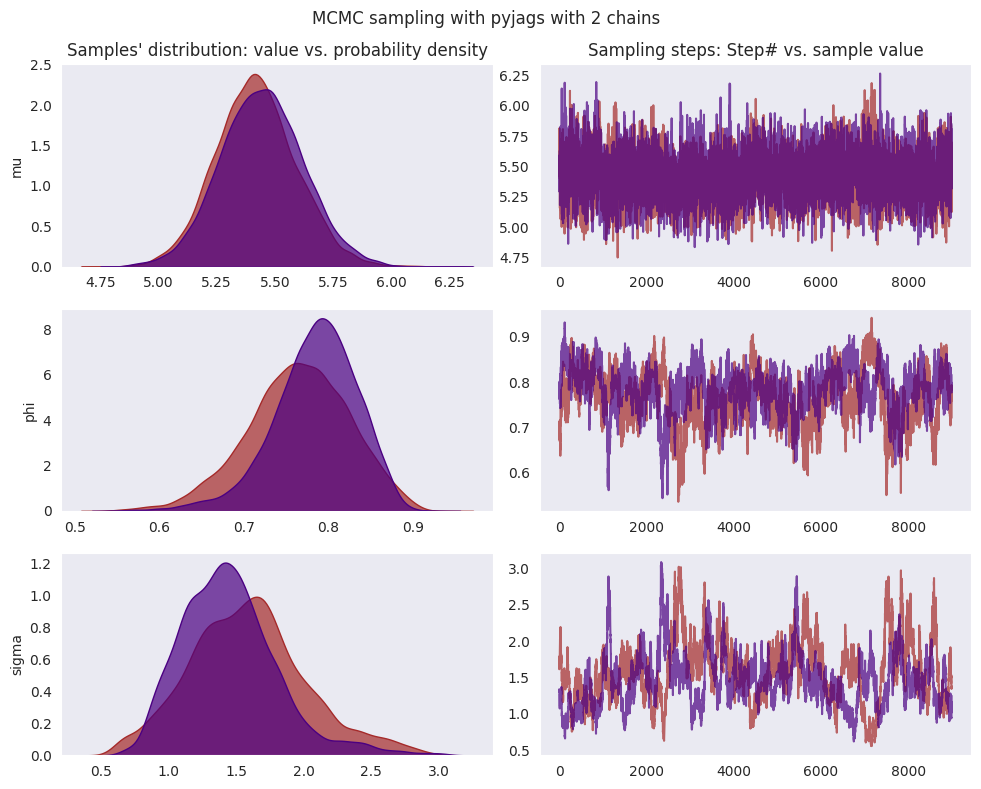

In [312]:
plot_samples(_sample_chains, parameters)

## Simulated data

In [443]:
'''
  generate data modelled as a skew normal distribution
  params:
    parameters for skew normal distribution
    a: skewness
    loc: location
    scale: scale
    n: number of asset returns to generate
  returns:
    returns n simulated asset_returns
'''
def gen_sim_data(a, loc, scale, n=1):
  return skewnorm.rvs(a=a, loc=loc, scale=scale, size=n)

In [444]:
# generate simulated data

sim_ar = gen_sim_data(a=25, loc=0, scale=1, n=2000)

In [ ]:
# Mean-correction

sim_x = np.mean(sim_ar)
corrected_sim_ar = [ar - sim_x for ar in sim_ar]
print(f'''Sim data (mean-corrected):
  Mean: {np.mean(corrected_sim_ar)},
  Var: {np.var(corrected_sim_ar)}'''
)

In [445]:
# Distribution information of simulated asset return data

_a, _loc, _scale = skewnorm.fit(corrected_sim_ar)
_mean, _var, _skew, _kurt = skewnorm.stats(_a, _loc, _scale, moments='mvsk')
print(f'''Simulated asset return data:
  Skewness: {_a}
  Location: {_loc}
  Scale: {_scale}
  Mean: {_mean}
  Variance: {_var}
  Skew: {_skew}
  Kurtosis: {_kurt}'''
)

Simulated asset return data:
  Shape: -0.8492936125781392
  Location: 2.2064867289752352
  Scale: 4.390533773077518
  Mean: -0.06122059401466373
  Variance: 14.134290309792293
  Skew: -0.09419187167219302
  Kurtosis: 0.03748613908482703


<AxesSubplot: ylabel='Density'>

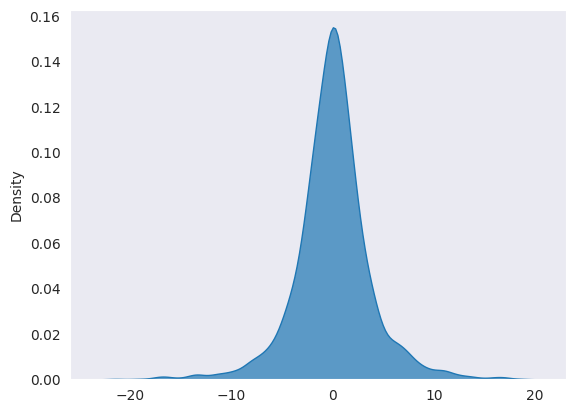

In [447]:
sns.kdeplot(data=corrected_sim_ar, fill=True, alpha=0.7)

In [448]:
########## Random initial values & setting proposal distribution paramters ###########

sim_sd = np.std(corrected_sim_ar)

# Mean log volatility(mu): draw randomly from a normal distribution with mean 0, SD of logarithmic returns
sim_mlv = np.random.normal(loc=0, scale=sim_sd)

# Persistence of volatility(phi): draw randomly from a uniform distribution between 0 to 1
sim_per = np.random.uniform(low=-1.0, high=1.0)

# Shock scale(sigma) distribution tends to be more heavy-tailed than the swing in prices itself
# We draw from distribution twice as wide as that for mlv
sim_ss = truncnorm.rvs(a=0, b=float('inf'), loc=0, scale=2*sim_sd)

sim_init_vals={'mu': sim_mlv, 'phi': sim_per, 'sigma': sim_ss}

print(f'''Initializer.....
  Mean log volatility: {sim_mlv}
  Persistence of volatility: {sim_per}
  Shock scale: {sim_ss}''')

Mean log volatility: 14.1810810407789
Shock: 28.3621620815578


adapting: iterations 320 of 2000, elapsed 0:00:10, remaining 0:00:52
adapting: iterations 654 of 2000, elapsed 0:00:21, remaining 0:00:43
adapting: iterations 964 of 2000, elapsed 0:00:32, remaining 0:00:34
adapting: iterations 1114 of 2000, elapsed 0:00:37, remaining 0:00:29
adapting: iterations 1416 of 2000, elapsed 0:00:46, remaining 0:00:19
adapting: iterations 1722 of 2000, elapsed 0:00:55, remaining 0:00:09
adapting: iterations 2000 of 2000, elapsed 0:01:01, remaining 0:00:00
adapting: iterations 2000 of 2000, elapsed 0:01:01, remaining 0:00:00
sampling: iterations 462 of 18000, elapsed 0:00:10, remaining 0:06:16
sampling: iterations 694 of 18000, elapsed 0:00:17, remaining 0:07:00
sampling: iterations 900 of 18000, elapsed 0:00:23, remaining 0:07:18
sampling: iterations 1294 of 18000, elapsed 0:00:31, remaining 0:06:41
sampling: iterations 1712 of 18000, elapsed 0:00:40, remaining 0:06:16
sampling: iterations 1928 of 18000, elapsed 0:00:45, remaining 0:06:13
sampling: iterations

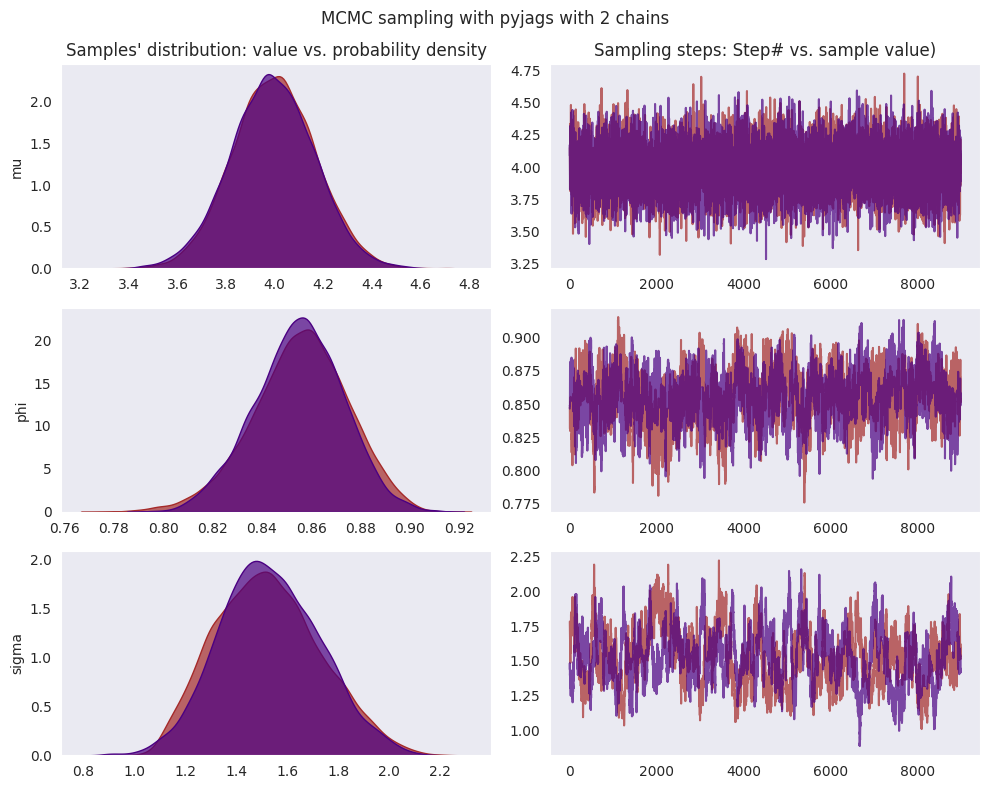


    Parameter: mu
      Means: [3.99685432 3.98942466], Modes: [4.013924040594813, 3.975504916083686]
      Confidence intervals (95%): [(3.9933292954937696, 4.000379352476475), (3.9858575780418337, 3.9929917452636423)]
      Gelman-Rubin Stat: 1.0004128943812545

    Parameter: phi
      Means: [0.85557896 0.85482298], Modes: [0.858433083334578, 0.8562522325242075]
      Confidence intervals (95%): [(0.8551780234664252, 0.8559798927400191), (0.8544538904639445, 0.8551920704145628)]
      Gelman-Rubin Stat: 1.0003551876650034

    Parameter: sigma
      Means: [1.52311354 1.53108791], Modes: [1.5108018874484346, 1.4778364524759322]
      Confidence intervals (95%): [(1.5188954992558166, 1.527331586770033), (1.5270417658470545, 1.5351340485573994)]
      Gelman-Rubin Stat: 1.0003417374048054


In [451]:
parameters = ['mu', 'phi', 'sigma']
sim_sample_chains = jags_sampling(dataset=corrected_sim_ar, mlv=sim_sd**2, ss=2*sim_sd**2, parameters=parameters, init_vals=sim_init_vals)

In [452]:
sim_posterior_info = extract_posterior_data(sim_sample_chains, parameters)
sim_posterior_info

{'mu': {'means': array([3.99685432, 3.98942466]),
  '95% HDIs': [(3.9933292954937696, 4.000379352476475),
   (3.9858575780418337, 3.9929917452636423)],
  'R': 1.0004128943812545,
  'modes': [4.013924040594813, 3.975504916083686]},
 'phi': {'means': array([0.85557896, 0.85482298]),
  '95% HDIs': [(0.8551780234664252, 0.8559798927400191),
   (0.8544538904639445, 0.8551920704145628)],
  'R': 1.0003551876650034,
  'modes': [0.858433083334578, 0.8562522325242075]},
 'sigma': {'means': array([1.52311354, 1.53108791]),
  '95% HDIs': [(1.5188954992558166, 1.527331586770033),
   (1.5270417658470545, 1.5351340485573994)],
  'R': 1.0003417374048054,
  'modes': [1.5108018874484346, 1.4778364524759322]}}

In [ ]:
plot_samples(sim_sample_chains, parameters)

In [ ]:
'''
  Now we try to validate our estimates,
  Plugging in values from posterior to see if we get the same estimates
'''

_sim_mlv=sim_posterior_info['mu']['modes'][0]
_sim_per=sim_posterior_info['phi']['modes'][0]
_sim_ss=sim_posterior_info['sigma']['modes'][0]
_sim_init_vals={'mu': _sim_mlv, 'phi': _sim_per, 'sigma': _sim_ss}
print(f'''Initializing from posterior samples' distribution
  mu: {_sim_mlv}
  phi: {_sim_per}
  sigma: {_sim_ss}''')

In [ ]:
_sim_sample_chains = jags_sampling(dataset=corrected_sim_ar, mlv=sim_sd**2, ss=2*sim_sd**2, parameters=parameters, init_vals=_sim_init_vals)

In [ ]:
_sim_posterior_info = extract_posterior_data(_sim_sample_chains, parameters)
_sim_posterior_info

In [ ]:
plot_samples(_sim_sample_chains, parameters)

## Asset return forecast

In [7]:
# data

fut = pd.read_csv('datasets/TSLA.csv')
print(fut.shape)
fut.head()

(2036, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,10/05/2018,17.46,18.31,18.33,17.33,269.17M,-7.08%
1,10/04/2018,18.79,19.60,19.60,18.51,147.21M,-4.38%
2,10/03/2018,19.65,20.22,20.31,19.44,119.92M,-2.09%
3,10/02/2018,20.07,20.93,21.12,19.94,176.15M,-3.09%
4,10/01/2018,20.71,20.38,20.76,20.07,326.66M,17.34%


In [8]:
fut.describe()

,Price,Open,High,Low
count,2036.000000,2036.000000,2036.000000,2036.000000
mean,11.450987,11.452638,11.647903,11.245172
std,7.508076,7.511246,7.621121,7.389974
min,1.300000,1.330000,1.340000,1.300000
25%,2.227500,2.220000,2.270000,2.180000
50%,13.520000,13.500000,13.730000,13.295000
75%,16.860000,16.842500,17.102500,16.630000
max,25.670000,25.780000,25.970000,25.290000


In [9]:
fut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2036 non-null   object 
 1   Price     2036 non-null   float64
 2   Open      2036 non-null   float64
 3   High      2036 non-null   float64
 4   Low       2036 non-null   float64
 5   Vol.      2036 non-null   object 
 6   Change %  2036 non-null   object 
dtypes: float64(4), object(3)
memory usage: 111.5+ KB


In [10]:
fut['Date'] = fut['Date'].apply(lambda dt: datetime.strptime(dt, "%m/%d/%Y"))

In [11]:
fut.sort_values(by='Date', inplace=True)
fut.head()

,Date,Price,Open,High,Low,Vol.,Change %
2035,2010-09-07,1.37,1.37,1.40,1.37,3.65M,-2.14%
2034,2010-09-08,1.39,1.38,1.40,1.37,4.33M,1.46%
2033,2010-09-09,1.38,1.40,1.40,1.38,5.64M,-0.72%
2032,2010-09-10,1.34,1.38,1.40,1.32,5.80M,-2.90%
2031,2010-09-13,1.38,1.39,1.39,1.37,5.41M,2.99%


In [12]:
fut['Asset_return'] = np.log(fut['Price'].shift(-1) / fut['Price']) * 100
fut[['Asset_return']] = fut[['Asset_return']].shift(1)
fut[['Asset_return']].head()

,Asset_return
2035,NaN
2034,1.449301
2033,-0.722025
2032,-2.941389
2031,2.941389


In [13]:
# splitting data into train & test blocks

fut_train = fut[fut['Date'] <= datetime.strptime("2018-09-06", "%Y-%m-%d")]
fut_train.head()

,Date,Price,Open,High,Low,Vol.,Change %,Asset_return
2035,2010-09-07,1.37,1.37,1.40,1.37,3.65M,-2.14%,NaN
2034,2010-09-08,1.39,1.38,1.40,1.37,4.33M,1.46%,1.449301
2033,2010-09-09,1.38,1.40,1.40,1.38,5.64M,-0.72%,-0.722025
2032,2010-09-10,1.34,1.38,1.40,1.32,5.80M,-2.90%,-2.941389
2031,2010-09-13,1.38,1.39,1.39,1.37,5.41M,2.99%,2.941389


In [14]:
fut_test = fut[fut['Date'] > datetime.strptime("2018-09-06", "%Y-%m-%d")]
fut_test.head()

,Date,Price,Open,High,Low,Vol.,Change %,Asset_return
20,2018-09-07,17.55,17.34,17.89,16.82,337.38M,-6.30%,-6.507257
19,2018-09-10,19.03,18.22,19.07,18.07,214.25M,8.43%,8.096273
18,2018-09-11,18.63,18.63,18.80,18.24,137.55M,-2.10%,-2.124350
17,2018-09-12,19.37,18.76,19.50,18.58,150.23M,3.97%,3.895229
16,2018-09-13,19.30,19.20,19.67,19.01,95.11M,-0.36%,-0.362038


In [15]:
fut_train_returns = fut_train[['Asset_return']].to_numpy().flatten()[1:]
fut_test_returns = fut_test[['Asset_return']].to_numpy().flatten()

In [16]:
# mean correction

tr_mean = fut_train_returns.mean()
fut_train_returns = fut_train_returns - tr_mean
ts_mean = fut_test_returns.mean()
fut_test_returns = fut_test_returns - ts_mean
print(fut_train_returns.mean(), fut_test_returns.mean())

3.528017555909137e-17 2.1147105230955362e-16


Training data variance: 9.809415492874853


<AxesSubplot: ylabel='Density'>

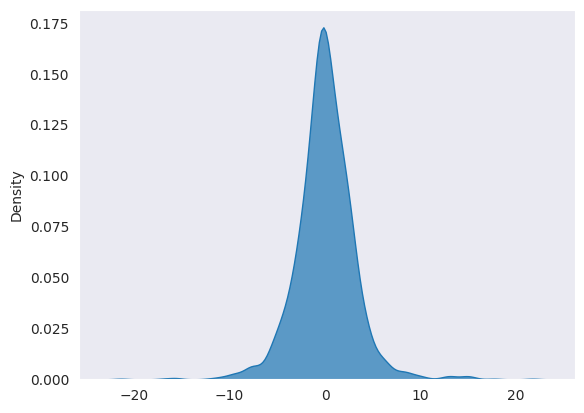

In [17]:
print(f'Training data variance: {np.var(fut_train_returns)}')
sns.kdeplot(data=fut_train_returns, fill=True, alpha=0.7)

In [18]:
########## Random initial values & setting proposal distribution paramters ###########

fut_sd = np.std(fut_train_returns)

# Mean log volatility(mu): draw randomly from a normal distribution with mean 0, SD of logarithmic returns
fut_mlv = np.random.normal(loc=0, scale=fut_sd)

# Persistence of volatility(phi): draw randomly from a uniform distribution between 0 to 1
fut_per = np.random.uniform(low=-1.0, high=1.0)

# Shock scale(sigma) distribution tends to be more heavy-tailed than the swing in prices itself
# We draw from distribution twice as wide as that for mlv
fut_ss = truncnorm.rvs(a=0, b=float('inf'), loc=0, scale=2*fut_sd)

fut_init_vals={'mu': fut_mlv, 'phi': fut_per, 'sigma': fut_ss}

print(f'''Initializer.....
  Mean log volatility: {fut_mlv}
  Persistence of volatility: {fut_per}
  Shock scale: {fut_ss}''')

Initializer.....
  Mean log volatility: -4.644946958045115
  Persistence of volatility: 0.7692145578034384
  Shock scale: 1.1588645125300625


In [19]:
parameters = ['mu', 'phi', 'sigma']
fut_samples = jags_sampling(dataset=fut_train_returns, mlv=fut_sd**2, ss=2*fut_sd**2, parameters=parameters, init_vals=fut_init_vals)

adapting: iterations 1540 of 2000, elapsed 0:00:08, remaining 0:00:02
adapting: iterations 2000 of 2000, elapsed 0:00:11, remaining 0:00:00
sampling: iterations 1600 of 18000, elapsed 0:00:09, remaining 0:01:33
sampling: iterations 3380 of 18000, elapsed 0:00:19, remaining 0:01:21
sampling: iterations 5180 of 18000, elapsed 0:00:29, remaining 0:01:12
sampling: iterations 6066 of 18000, elapsed 0:00:36, remaining 0:01:10
sampling: iterations 7766 of 18000, elapsed 0:00:46, remaining 0:01:00
sampling: iterations 8618 of 18000, elapsed 0:00:54, remaining 0:00:59
sampling: iterations 10204 of 18000, elapsed 0:01:04, remaining 0:00:49
sampling: iterations 11000 of 18000, elapsed 0:01:10, remaining 0:00:44
sampling: iterations 11788 of 18000, elapsed 0:01:17, remaining 0:00:41
sampling: iterations 12550 of 18000, elapsed 0:01:24, remaining 0:00:36
sampling: iterations 13298 of 18000, elapsed 0:01:29, remaining 0:00:32
sampling: iterations 14794 of 18000, elapsed 0:01:37, remaining 0:00:21
sa

In [20]:
fut_posterior_info = extract_posterior_data(sample_chains=fut_samples, parameters=parameters)
fut_posterior_info


CHAINS: 2, ITERS: 9000, BURN-IN: 1000


{'mu': {'means': array([3.5861156 , 3.59373738]),
  'modes': [3.5865007695922064, 3.5936110783159436],
  'intervals': [[3.3580002116930947, 3.8189052660967353],
   [3.359993630382507, 3.8279122059467072]],
  'R': 1.0009700323428505},
 'phi': {'means': array([0.61503744, 0.62145265]),
  'modes': [0.6151814206446642, 0.6212650903515017],
  'intervals': [[0.467101594707758, 0.7473896110108832],
   [0.4642034145507174, 0.7415323630427819]],
  'R': 1.001936420066283},
 'sigma': {'means': array([2.20298014, 2.15215009]),
  'modes': [2.197680784046012, 2.144930029240091],
  'intervals': [[1.4308194609881564, 3.0996463015269446],
   [1.4373505125260013, 3.0882332716636203]],
  'R': 1.0036340817476272}}

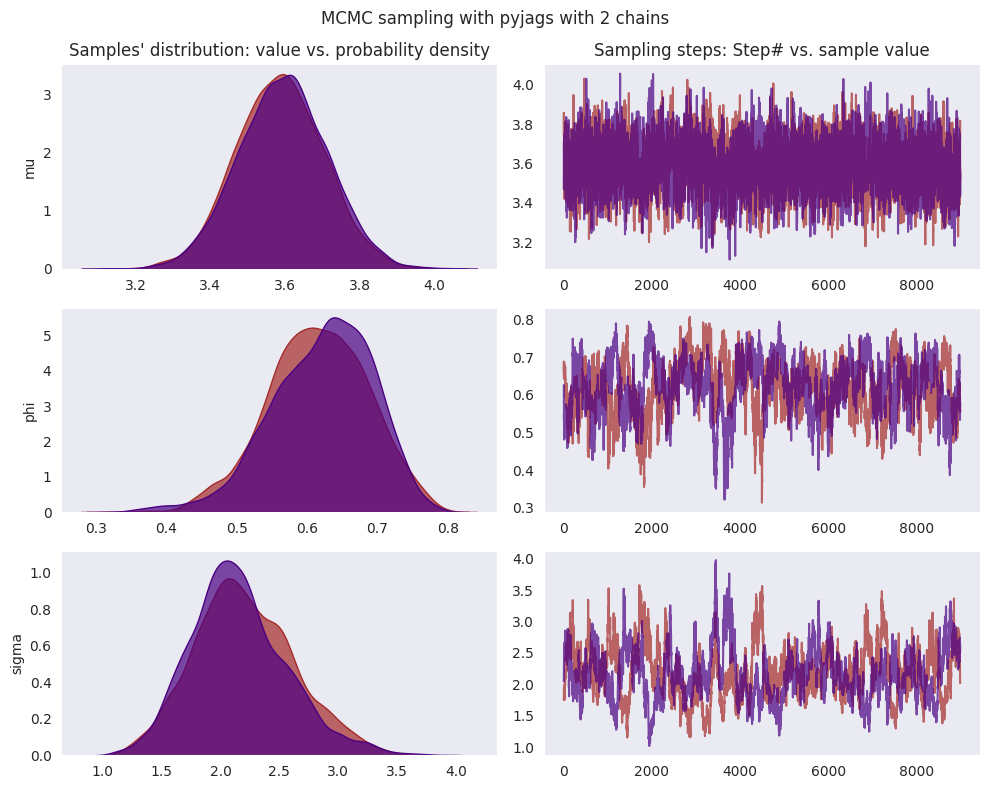

In [21]:
plot_samples(fut_samples, parameters)

In [22]:
_fut_mlv=fut_posterior_info['mu']['modes'][0]
_fut_per=fut_posterior_info['phi']['modes'][0]
_fut_ss=fut_posterior_info['sigma']['modes'][0]
print(f'''Initializing from posterior samples' distribution
  mu: {_fut_mlv}
  phi: {_fut_per}
  sigma: {_fut_ss}''')

Initializing from posterior samples' distribution
  mu: 3.5865007695922064
  phi: 0.6151814206446642
  sigma: 2.197680784046012


In [23]:
'''
  generate bounds for prediction for Basic SVOL
  params:
    model params
    most recent volatility 'ivol'
    # of predictions: n
'''
def gen_pred_bounds(mu, phi, sigma, ivol, n=1):
  
  lowers = []
  uppers = []
  alpha = 0.05
  prev_lo, prev_hi = ivol, ivol
  
  for _ in range(n):
    lo = norm.ppf(alpha/2, mu + phi*(prev_lo - mu), np.sqrt(sigma))
    hi = norm.ppf(1 - alpha/2, mu + phi*(prev_hi - mu), np.sqrt(sigma))
    lowers.append(lo)
    uppers.append(hi)
    prev_lo, prev_hi = lo, hi
  
  return lowers, uppers

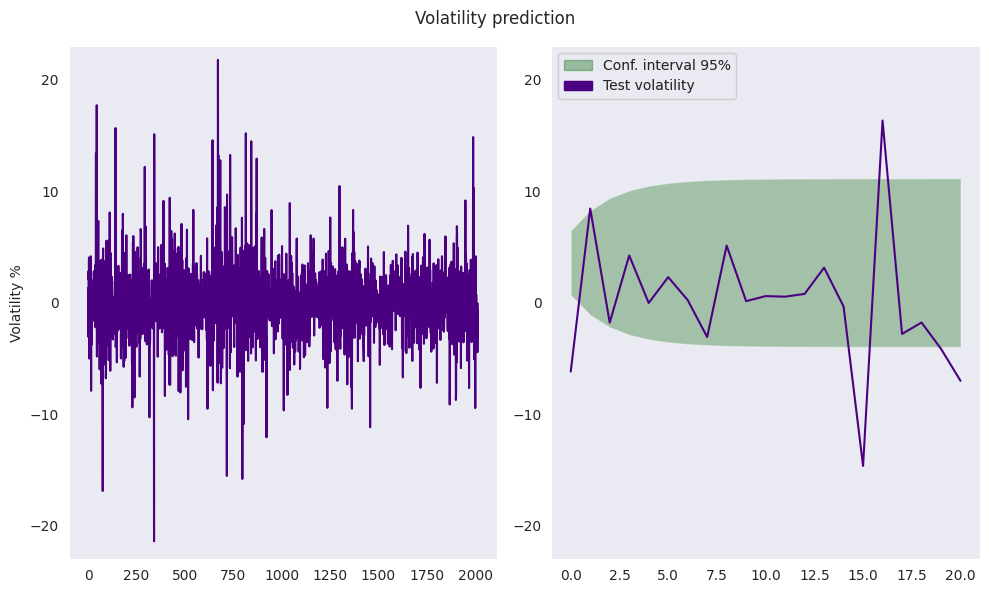

In [28]:
# mode of posterior mu to be picked as initial volatility
fut_preds = gen_pred_bounds(mu=_fut_mlv, phi=_fut_per, sigma=_fut_ss, ivol=_fut_mlv, n=len(fut_test_returns) )

# plot prediction area with actual volatility values
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

sns.lineplot(data=fut_train_returns, ax=axs[0], color='indigo')
axs[0].set_ylim(-23, 23)
axs[0].set(ylabel='Volatility %')

sns.lineplot(data=fut_test_returns, ax=axs[1], color='indigo')
axs[1].fill_between(range(len(fut_test_returns)), fut_preds[0], fut_preds[1], facecolor='darkgreen', alpha=0.3)
axs[1].set_ylim(-23, 23)

patch1 = mpatches.Patch(color='darkgreen', label='Conf. interval 95%', alpha=0.3)
patch2 = mpatches.Patch(color='indigo', label='Test volatility')

# Create the legend with custom elements
legend = axs[1].legend(handles=[patch1, patch2], loc='upper left')

# Add the legend to the axes
axs[1].add_artist(legend)

fig.suptitle('Volatility prediction')
plt.tight_layout()